In [66]:
import qiskit
qiskit.__qiskit_version__
from qiskit.visualization import plot_histogram
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.optimize as optimize

In [67]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
#from qiskit_operators import op_converter
#from qiskit_operators import WeightedPauliOperator
import qiskit 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
from time import time
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA,COBYLA,SLSQP
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
import numpy as np
import copy

from qiskit_optimization.algorithms import CobylaOptimizer,SlsqpOptimizer
# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

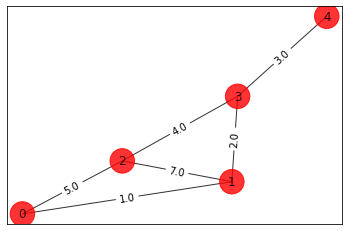

In [68]:


def bipartite():
   
    n = 5 # Number of nodes in graph
    G = nx.Graph()
    G.add_nodes_from(np.arange(0,n,1))
    elist = [(0,3,1.0),(0,4,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,1.0)]
    # tuple is (i,j,weight) where (i,j) is the edge
    G.add_weighted_edges_from(elist)
    
    return G

G=bipartite()
nx.draw(G)

def bitstring_to_array(x):
        return np.array([int(d) for d in str(x)])
n=len(G)    


n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,5.0),(1,2,7.0),(3,2,4.0),(1,3,2.0),(3,4,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

In [69]:
def objective(G, x):
    '''Calculating the value of a cut x on graph G, 
    where x is represented by a numpy array of 1s and 0s
    '''
    w = nx.to_numpy_array(G)
    spin = pow(-1,x) # bijection from 0,1 to 1,-1
    
    return 0.5*sum([w[i,j]*(1-spin[i]*spin[j]) for i,j in G.edges]) 

def create_circuit(G, gamma, beta):
    
    if len(beta) == len(gamma):
        p = len(beta)
    else:
        raise ValueError("The parameter array beta must have the same length as parameter gamma")
    
    n = len(G)
    circ = qiskit.QuantumCircuit(n)
    
  
    thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

    for idx, theta in enumerate(thetas):
        circ.ry(theta, idx)
        
        
    for i in range(p):
        for a,b in G.edges:
            circ.cx(a,b)
            circ.rz(-gamma[i],b) 
            circ.cx(a,b)
        circ.barrier()
        
        for idx, theta in enumerate(thetas): 
            circ.ry(-theta, idx)
            circ.rz(-2*beta[i], idx)
            circ.ry(theta, idx)    
            
    
    circ.measure_all()
    
    return circ

def expectation(G, gamma, beta, backend, n_samples = 1024):
    
    
    # create circuit and run it n_shots times
    r,counts = sample(G, gamma, beta, backend, n_samples = n_samples)
    
    def bitstring_to_array(x):
        return np.array([int(d) for d in str(x)])
    
    avg = sum([counts[x] * objective(G,bitstring_to_array(x)) for x in counts])/n_samples
    
    return avg

def find_local_angles(G, gamma, beta, backend, n_samples = 1024, optimizer = 'COBYLA', optimizer_options = None):
    

    def fun(angles):
        ''' The objective function to be optimised by varying the angles
        Note, we want to maximize the expectation <Hc>, this is equivalent to 
        minimizing - <Hc>'''
        new_gamma = angles[:len(angles)//2]
        new_beta = angles[len(angles)//2:]
        
        # maximize f = minimize -f 
        return -expectation(G, new_gamma, new_beta, backend, n_samples) 
    
    x0 = gamma+beta
    result = scipy.optimize.minimize(fun, x0, method= optimizer)
    
    # finding angles
    angles = result.x
    new_gamma = angles[:len(angles)//2]
    new_beta = angles[len(angles)//2:]
    return result,new_gamma, new_beta
  

    
def sample(G, gamma, beta, backend, n_samples = 1024, plot_histogram = False):
    circ = create_circuit(G,beta,gamma)
    
    result = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots = n_samples,coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
    counts = result.get_counts()
    counts=invert_counts(counts)
    if plot_histogram:
        from qiskit.tools.visualization import plot_histogram
        plot_histogram(counts)
        
    return result,counts

def get_angles_INTERP(G, p, backend, initial_gamma = [1.2], initial_beta = [2]):
    '''
    Finds quasi-optimal angles for a given graph G
    Iteratively p is increased, using INTERP
    to find initial points for optimization
    '''
    
    def INTERP_next_angles(angles):
        '''Takes in a set of p angles and returns a new set of p+1 angles using the INTERP method'''
        
        assert len(gamma) == len(beta), "Both lists of parameters gamma, beta must be of the same length"
        
        p = len(angles)
        
        new_angles = [angles[0]] # i = 1, the first angles coincide
        for i in range(2, p+1):
            new_angles.append( (i-1)/p*angles[i-2] + (p-i+1)/p*angles[i-1]) # i in {2, ... , p}, interpolation 
        new_angles.append(angles[-1]) # i = p+1, the last angles coincide
            
        return new_angles

    
    result,gamma,beta = find_local_angles(G,initial_gamma,initial_beta,backend)
    
    for i in range(p-1):
        gamma_ansatz,beta_ansatz = INTERP_next_angles(gamma), INTERP_next_angles(beta) # new initial points
        print("ansatz gamma, beta", gamma_ansatz, beta_ansatz)
        result,gamma,beta = find_local_angles(G,gamma_ansatz,beta_ansatz,backend) # new (local) optima  
        print("RESULT", result, gamma, beta)
    
    return result,gamma, beta

def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

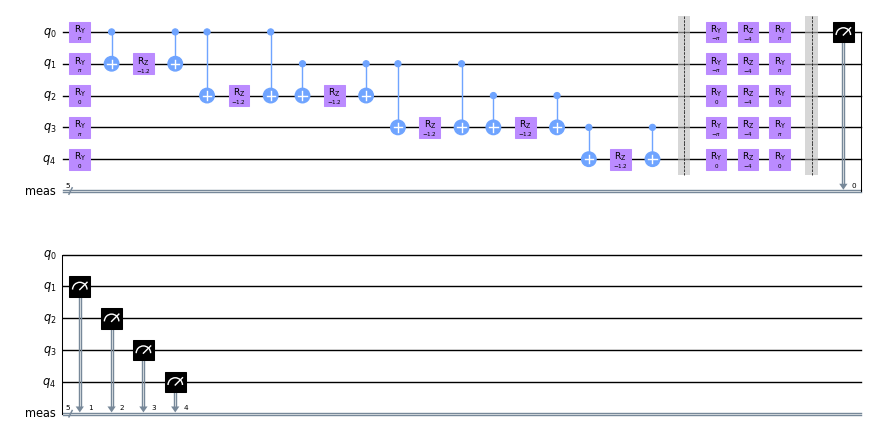

In [70]:


circ=create_circuit(G, [1.2], [2])
circ.draw(output='mpl',scale=0.7)

In [71]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 5. 0. 0.]
 [1. 0. 7. 2. 0.]
 [5. 7. 0. 4. 0.]
 [0. 2. 4. 0. 3.]
 [0. 0. 0. 3. 0.]]


In [72]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qp.to_docplex().prettyprint()
#CplexOptimizer().solve(qp)

// This file has been generated by DOcplex
// model name is: Max-cut
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

maximize
 6 x_0 + 10 x_1 + 16 x_2 + 9 x_3 + 3 x_4 [ - 2 x_0*x_1 - 10 x_0*x_2
 - 14 x_1*x_2 - 4 x_1*x_3 - 8 x_2*x_3 - 6 x_3*x_4 ];
 
subject to {

}


In [73]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem


In [74]:
qp1 = relax_problem(QuadraticProgramToQubo().convert(qp))
qp1
optimizer = CobylaOptimizer()
result = optimizer.solve(qp1) 
result

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS

In [75]:
c_stars = result.samples[0].x
c_stars

array([1., 1., 0., 1., 0.])

In [76]:

thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]


In [77]:
print(thetas)

[3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793, 0.0]


In [78]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qp.to_docplex().prettyprint()
#CplexOptimizer().solve(qp)

// This file has been generated by DOcplex
// model name is: Max-cut
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

maximize
 6 x_0 + 10 x_1 + 16 x_2 + 9 x_3 + 3 x_4 [ - 2 x_0*x_1 - 10 x_0*x_2
 - 14 x_1*x_2 - 4 x_1*x_3 - 8 x_2*x_3 - 6 x_3*x_4 ];
 
subject to {

}


In [79]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem





#qubitOp, offset = qp.to_ising()
#print('Offset:', offset)
#print('Ising Hamiltonian:')
#print(str(qubitOp))

In [98]:
t0=time()
result,optimal_gamma,optimal_beta=get_angles_INTERP(G, 2, backend, initial_gamma = [0.], initial_beta = [1.])
result1,S = sample(G, optimal_gamma,optimal_beta, backend, n_samples = 1024, plot_histogram=True)
time()-t0

ansatz gamma, beta [1.0555750687036718, 1.0555750687036718] [2.0446690155486187, 2.0446690155486187]
RESULT      fun: -11.962890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 46
  status: 1
 success: True
       x: array([1.57706903, 0.77811657, 3.53656441, 1.01970499]) [1.57706903 0.77811657] [3.53656441 1.01970499]


22.318591594696045

In [99]:
result1

Result(backend_name='qasm_simulator', backend_version='0.7.6', qobj_id='17e110f5-dfac-47db-b76c-4d8e6a2c299e', job_id='520e1192-588c-4a3f-b9ef-00a96113cb6d', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x0': 89, '0x1': 107, '0x10': 12, '0x11': 7, '0x12': 8, '0x13': 9, '0x14': 1, '0x15': 2, '0x16': 5, '0x17': 3, '0x18': 6, '0x19': 4, '0x1a': 17, '0x1b': 15, '0x1c': 4, '0x1e': 1, '0x1f': 2, '0x2': 40, '0x3': 66, '0x4': 26, '0x5': 23, '0x6': 16, '0x7': 25, '0x8': 85, '0x9': 83, '0xa': 82, '0xb': 160, '0xc': 26, '0xd': 22, '0xe': 36, '0xf': 42}), header=QobjExperimentHeader(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2], ['meas', 3], ['meas', 4]], creg_sizes=[['meas', 5]], global_phase=1.5707963267948957, memory_slots=5, metadata=None, n_qubits=15, name='circuit-3875', qreg_sizes=[['q', 15]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7], ['q', 8], [

In [100]:
S

{'00000': 89,
 '10000': 107,
 '00001': 12,
 '10001': 7,
 '01001': 8,
 '11001': 9,
 '00101': 1,
 '10101': 2,
 '01101': 5,
 '11101': 3,
 '00011': 6,
 '10011': 4,
 '01011': 17,
 '11011': 15,
 '00111': 4,
 '01111': 1,
 '11111': 2,
 '01000': 40,
 '11000': 66,
 '00100': 26,
 '10100': 23,
 '01100': 16,
 '11100': 25,
 '00010': 85,
 '10010': 83,
 '01010': 82,
 '11010': 160,
 '00110': 26,
 '10110': 22,
 '01110': 36,
 '11110': 42}

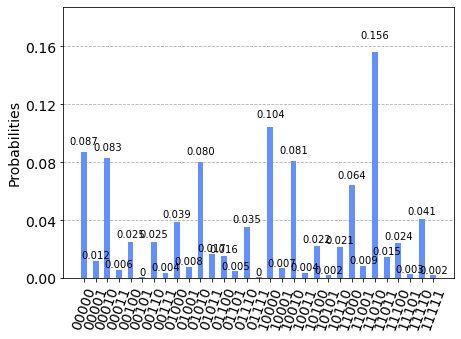

In [101]:
plot_histogram(S)

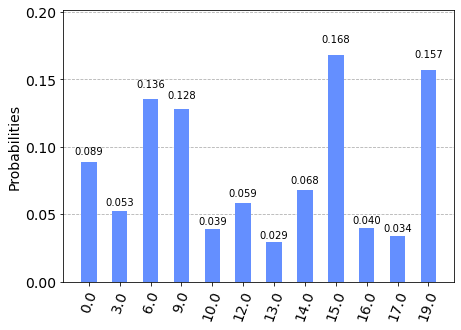

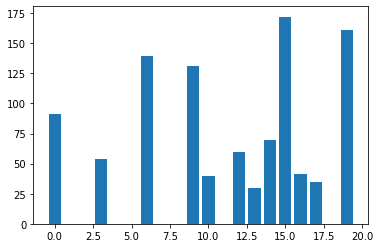

In [102]:
energies = defaultdict(int)
for k, v in S.items():
    z = bitstring_to_array(k)
    energies[objective(G,z)]+=v
x,y = zip(*energies.items())
plt.bar(x,y)



plot_histogram(energies)

In [103]:
IBMQ.save_account('5594783ef89d2bc321855a20a910bcce2745cad0df58cf66953d1e993c4d71111cb595eb0a8486a278e3d68e8ace8f9c6e998f98d6444cd440f5e41787b91d36',overwrite=True)

In [104]:
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise



provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend)
# Set coupling map from backend
coupling_map = backend.configuration().coupling_map
# Set basis gates from noise model
basis_gates = noise_model.basis_gates


ibmqfactory.load_account:WARNING:2021-05-29 20:37:22,021: Credentials are already in use. The existing account in the session will be replaced.


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


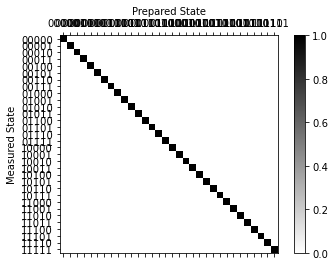

[[0.901 0.036 0.064 ... 0.    0.    0.   ]
 [0.007 0.864 0.    ... 0.    0.    0.001]
 [0.018 0.    0.865 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.753 0.    0.031]
 [0.    0.    0.    ... 0.004 0.728 0.033]
 [0.    0.    0.    ... 0.011 0.005 0.706]]


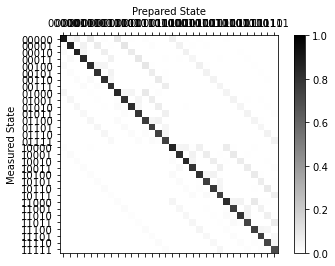

In [105]:
qr = QuantumRegister(5)
qubit_list = [0,1,2,3,4]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

# With noise.
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal1_results = job.result()
meas_fitter = CompleteMeasFitter(cal1_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)


meas_fitter.plot_calibration()


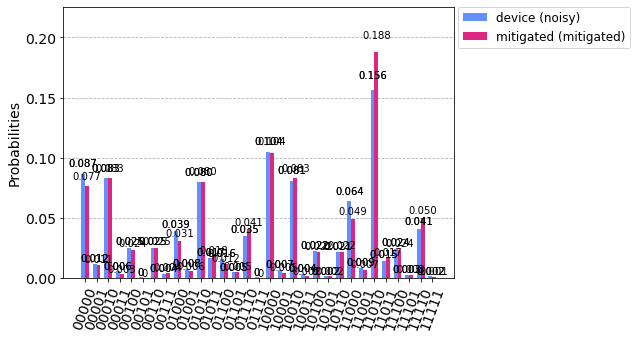

In [106]:
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result1)
mitigated_counts = invert_counts(mitigated_results.get_counts(0))
plot_histogram([S, mitigated_counts], legend=['device (noisy)', 'mitigated (mitigated)'],color=['#648fff','#dc267f'])



In [107]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)


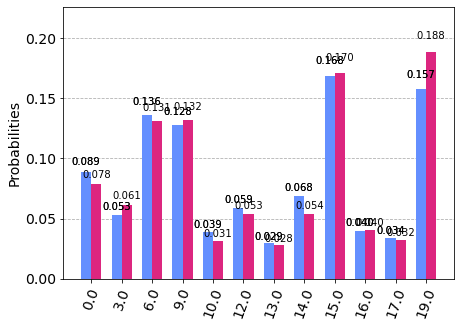

In [108]:







energies = defaultdict(int)
for k, v in S.items():
    z = bitstring_to_array(k)
    energies[objective(G,z)]+=v
x,y = zip(*energies.items())
#plt.bar(x,y)
energies1 = defaultdict(int)
for k, v in mitigated_counts.items():
    z = bitstring_to_array(k)
    energies1[objective(G,z)]+=v
x,y = zip(*energies.items())


plot_histogram([energies,energies1])